# Theme Analysis

In this notebook, theme analysis is carried out using different methods: Latent Dirichlet Allocation and Zero-shot classification.

### 1. Connect with Snowflake

In [ ]:
import snowflake.connector as sc
import os
from dotenv import load_dotenv

# Connecting to Snowflake using the default authenticator
load_dotenv(override=True) 

ctx = sc.connect(
    user=os.getenv("USER").strip(),
    password=os.getenv("PASSWORD").strip(),
    account=os.getenv("ACCOUNT").strip(),
    warehouse=os.getenv("WAREHOUSE").strip(),
    database=os.getenv("DATABASE").strip(),
    schema=os.getenv("SCHEMA").strip(),
    role=os.getenv("ROLE").strip()
)


cs = ctx.cursor()

In [49]:
from snowflake.snowpark import Session

connection_parameters = {
    "user":os.getenv("USER").strip(),
    "password":os.getenv("PASSWORD").strip(),
    "account":os.getenv("ACCOUNT").strip(),
    "warehouse":os.getenv("WAREHOUSE").strip(),
    "database":os.getenv("DATABASE").strip(),
    "schema":os.getenv("SCHEMA").strip(),
    "role":os.getenv("ROLE").strip()
}

new_session = Session.builder.configs(connection_parameters).create()

In [4]:
new_session.table("FCT_REVIEW_ENRICHED").show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"REVIEW_ID"  |"CUSTOMER_ID"  |"DATE_SUBMITTED_ID"  |"DATE_FLOWN_ID"  |"ORIGIN_LOCATION_ID"  |"DESTINATION_LOCATION_ID"  |"TRANSIT_LOCATION_ID"  |"AIRCRAFT_ID"  |"AIRLINE"                       |"VERIFIED"  |"SEAT_TYPE"      |"TYPE_OF_TRAVELLER"  |"SEAT_COMFORT"  |"CABIN_STAFF_SERVICE"  |"FOOD_AND_BEVERAGES"  |"INFLIGHT_ENTERTAINMENT"  |"GROUND_SERVICE"  |"WIFI_AND_CONNECTIVITY"  |"VALUE_FOR_MONEY"  |"RECOMMENDED"  |"AVERAGE_RATING"  |"

### 2. Text preprocessing
This step involves:
- Removing stop words, punctuation, and other irrelevant symbols
- Perform lemmatization to reduce words to their base form

In [1]:
import snowflake.snowpark.functions as F
import pandas as pd

In [ ]:
query = """
SELECT *
FROM SKYTRAX_REVIEWS_DB.MARTS.FCT_REVIEW_ENRICHED
WHERE AIRLINE = 'Qantas Airways';
"""

df = pd.read_sql(query, ctx)  # ctx is your Snowflake connection
df.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_30796\2941254177.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, ctx)  # ctx is your Snowflake connection


,REVIEW_ID,CUSTOMER_ID,DATE_SUBMITTED_ID,DATE_FLOWN_ID,ORIGIN_LOCATION_ID,DESTINATION_LOCATION_ID,TRANSIT_LOCATION_ID,AIRCRAFT_ID,AIRLINE,VERIFIED,...,INFLIGHT_ENTERTAINMENT,GROUND_SERVICE,WIFI_AND_CONNECTIVITY,VALUE_FOR_MONEY,RECOMMENDED,AVERAGE_RATING,RATING_BAND,REVIEW_TEXT,EL_UPDATED_AT,T_UPDATED_AT
0,145208,15770,2024-01-30,2024-01-01,2822,4135,4732,7,Qantas Airways,True,...,1.0,1.0,1.0,1.0,False,1.29,bad,The management of Airline and reputation is ho...,2025-08-07 02:52:20,2025-08-06 20:53:11.639
1,110843,16105,2020-09-17,2019-12-01,2822,631,4732,42,Qantas Airways,True,...,NaN,1.0,NaN,1.0,False,1.00,bad,I had my tickets cancelled (without notificati...,2025-08-07 02:52:20,2025-08-06 20:53:11.639
2,148468,16753,2024-07-03,2024-06-01,1146,4356,4732,19,Qantas Airways,True,...,4.0,2.0,4.0,2.0,True,3.14,medium,Significant delays with first announcement mad...,2025-08-07 02:52:20,2025-08-06 20:53:11.639
3,104023,16899,2019-11-27,2019-07-01,598,265,4732,42,Qantas Airways,True,...,1.0,1.0,1.0,1.0,False,1.00,bad,Brisbane to Auckland in April 2019. This was t...,2025-08-07 02:52:20,2025-08-06 20:53:11.639
4,106509,17821,2020-01-21,2020-01-01,3447,688,598,19,Qantas Airways,True,...,1.0,2.0,1.0,1.0,False,1.57,bad,Perth to Cairns via Brisbane. For a long time ...,2025-08-07 02:52:20,2025-08-06 20:53:11.639


In [6]:
import nltk
import string
import spacy
nlp = spacy.load("en_core_web_sm")

def text_processing(reviews, removal_words=[]):
    removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM'] # tags that we want to remove

    tokens = []
    for review in nlp.pipe(reviews): # tokenize
        # remove stopwords and lemmatise
        proj_tok = [token.lemma_.lower() for token in review if token.pos_ not in removal and not token.is_stop and token.is_alpha]
        proj_tok = [token for token in proj_tok if token not in removal_words]
        tokens.append(proj_tok)

    return tokens



In [4]:
# First processing
sk_tokenized_docs = text_processing(df["REVIEW_TEXT"])

In [5]:
from nltk.probability import FreqDist

fdist = FreqDist([word for tokens in sk_tokenized_docs for word in tokens])
fdist_df = pd.DataFrame.from_dict(dict(fdist.items()), orient='index', columns=['freq'])
fdist_df.sort_values(by='freq', ascending=False)[:25]

,freq
flight,3368
qantas,2519
service,1347
seat,1223
time,1055
sydney,942
hour,890
fly,849
good,807
crew,790


In [6]:
extension = fdist_df[fdist_df.freq>800].index.tolist()
extension.extend(["airline", "tell", "say", "melbourne", "go", "give", "singapore", "brisbane"])
extension

['qantas',
 'flight',
 'time',
 'service',
 'seat',
 'hour',
 'fly',
 'sydney',
 'good',
 'airline',
 'tell',
 'say',
 'melbourne',
 'go',
 'give',
 'singapore',
 'brisbane']

In [7]:
# Process again
sk_tokenized_docs = text_processing(df["REVIEW_TEXT"], extension)

In [8]:
fdist = FreqDist([word for tokens in sk_tokenized_docs for word in tokens])
fdist_df = pd.DataFrame.from_dict(dict(fdist.items()), orient='index', columns=['freq'])
fdist_df.sort_values(by='freq', ascending=False)[:50]

,freq
crew,790
food,743
staff,668
meal,615
cabin,597
check,565
business,555
class,499
delay,467
experience,457


In [9]:
# Transform tokens matrix into count matrix
from sklearn.feature_extraction.text import CountVectorizer

cv_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
cv_arr = cv_vectorizer.fit_transform(sk_tokenized_docs)
vocab = cv_vectorizer.get_feature_names_out()

d:\Lam\ProgrammingProject\Data\SkylineReview\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 3. Latent Dirichlet Allocation

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7,  max_iter=100, random_state=42, batch_size=2000, learning_offset=100, learning_decay=0.6)
lda.fit_transform(cv_arr)

topic_words = lda.components_

In [11]:
lda.score(cv_arr)

np.float64(-560358.8679143599)

Hyperparameter Selection


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define LDA
lda = LatentDirichletAllocation(random_state=0, n_components=5, learning_method='online', total_samples=len(sk_tokenized_docs))

# Parameter distributions
param_dist = {
    'max_iter': [100, 150, 200],
    'learning_decay': [0.6, 0.7, 0.8],
    'batch_size': [1000, 1500, 2000],
    'learning_offset': [10, 50, 100]
}

# Randomized search
search = RandomizedSearchCV(
    lda,
    param_distributions=param_dist,
    n_iter=60,
    random_state=0,
    n_jobs=-1,
    verbose=1
)

search.fit(cv_arr, y=None)

print("Best params:", search.best_params_)
print("Best log-likelihood score:", search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'max_iter': 200, 'learning_offset': 100, 'learning_decay': 0.8, 'batch_size': 1500}
Best log-likelihood score: -127032.4223299949


In [ ]:
# Parameter distributions
scores = []
for i in range(1, 11, 1):
    lda = LatentDirichletAllocation(random_state=0, n_components=i, max_iter=200, learning_offset=100, learning_decay=0.8, batch_size=1500, learning_method='online', total_samples=len(sk_tokenized_docs))
    lda.fit_transform(cv_arr)
    scores.append(lda.perplexity(cv_arr))

Number of Topics Selection

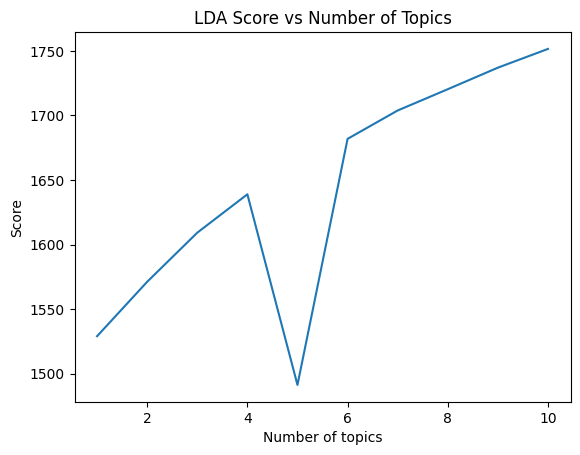

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11, 1), scores)
plt.xlabel("Number of topics")
plt.ylabel("Score")
plt.title("LDA Score vs Number of Topics")
plt.show()

In [ ]:
lda = LatentDirichletAllocation(random_state=0, n_components=6, max_iter=200, learning_offset=100, learning_decay=0.8, batch_size=1500, learning_method='online', total_samples=len(sk_tokenized_docs))
topics = lda.fit_transform(cv_arr)
topic_words = lda.components_

Extract topic words that have highest probability in each topic

In [93]:
import numpy as np

n_words = 15

for i, topic_dist in enumerate(topic_words):
    sorted_topic_dist = np.argsort(topic_dist)

    topic_words_sorted = np.array(vocab)[sorted_topic_dist]

    topic_words_sorted = topic_words_sorted[:-n_words:-1]

    print(f"Topic {i}: {topic_words_sorted}")
    

Topic 0: ['delay' 'class' 'plane' 'cabin' 'depart' 'aircraft' 'business' 'journey'
 'staff' 'ife' 'experience' 'emirates' 'screen' 'attendant']
Topic 1: ['food' 'business' 'staff' 'meal' 'class' 'serve' 'plane' 'pay' 'friendly'
 'luggage' 'bag' 'perth' 'find' 'cabin']
Topic 2: ['meal' 'cabin' 'food' 'serve' 'economy' 'staff' 'drink' 'offer'
 'experience' 'class' 'friendly' 'check' 'passenger' 'plane']
Topic 3: ['staff' 'check' 'delay' 'arrive' 'food' 'cabin' 'class' 'business' 'day'
 'bag' 'experience' 'plane' 'provide' 'passenger']
Topic 4: ['experience' 'customer' 'day' 'delay' 'ticket' 'staff' 'book' 'get' 'pay'
 'travel' 'cancel' 'food' 'plane' 'business']
Topic 5: ['experience' 'cabin' 'staff' 'arrive' 'food' 'check' 'meal' 'delay'
 'passenger' 'friendly' 'comfortable' 'class' 'customer' 'entertainment']


In [94]:
topic_labels = {
    0: "DELAYS_AND_DISRUPTIONS|CABIN_INFLIGHT_EXPERIENCE|STAFF_AND_SERVICE|CLASS_AND_AIRLINE",
    1: "FOOD_AND_BEVERAGE|STAFF_AND_SERVICE|GROUND_SERVICE|CLASS_AND_AIRLINE",
    2: "FOOD_AND_BEVERAGE|CABIN_INFLIGHT_EXPERIENCE|STAFF_AND_SERVICE|GROUND_SERVICE|CLASS_AND_AIRLINE",
    3: "DELAYS_AND_DISRUPTIONS|FOOD_AND_BEVERAGE|STAFF_AND_SERVICE|GROUND_SERVICE|CLASS_AND_AIRLINE",
    4: "DELAYS_AND_DISRUPTIONS|STAFF_AND_SERVICE|GROUND_SERVICE|CLASS_AND_AIRLINE|CUSTOMER_EXPERIENCE_VALUE",
    5: "CABIN_INFLIGHT_EXPERIENCE|FOOD_AND_BEVERAGE|STAFF_AND_SERVICE|DELAYS_AND_DISRUPTIONS|CUSTOMER_EXPERIENCE_VALUE"
}


# Your existing code for getting review topics
review_topics = []

for n in range(len(df['REVIEW_TEXT'])):
    review_topics.append(topics[n].argmax())

# Convert numeric topics to labels
review_topic_labels = [topic_labels[topic] for topic in review_topics]

### Zero shot classification

In [1]:
import torch
print(torch.version.__version__)         # PyTorch CUDA version
print(torch.cuda.is_available())  # should be True if GPU works
print(torch.cuda.get_device_name(0))


2.8.0+cu126
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
from transformers import pipeline

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

d:\Lam\ProgrammingProject\Data\SkylineReview\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


Define labels

In [ ]:
labels = [
    "Cabin Comfort",           # Seat space, cleanliness, overall comfort
    "Food and Beverages",      # Meals, snacks, drinks quality
    "Staff Service",           # Cabin crew friendliness, professionalism
    "Delays and Disruptions",  # Flight delays, cancellations, missed connections
    "Airport Service",         # Check-in, security, boarding, lounge, ground staff
    "Baggage Handling",        # Lost luggage, late delivery, damaged bags
    "Inflight Entertainment",  # Movies, music, Wi-Fi, screens, magazines
    "Value for Money",         # Ticket price fairness, perceived worth
    "Booking and Ticketing"    # Website/app issues, payment problems, seat selection
]


result = classifier(df['REVIEW_TEXT'].iloc[0], labels)

In [10]:
result

{'sequence': 'The management of Airline and reputation is horrendous. Qantas has the reputation of constant delays and cancellations to the point that it is of no surprise anymore. Airline cleanliness is not up to standards and aircrew are not as friendly as other airlines. For this current flight, it was plagued with delays, firstly with boarding, even though the aircrew boarded the aircraft before the first boarding call. Subsequently, we only managed to board past the flight time and were then told to wait another 20 minutes due to paperworks issue. This is a full paying flight and not a budget flight, but we were told after they sorted out the paperworks that unfortunately the flight could not have in-flight entertainment. The flight is double the budget airline in price but ended up with no in-flight entertainment. This deserves a budget and low rating.',
 'labels': ['Delays and Disruptions',
  'Inflight Entertainment',
  'Booking and Ticketing',
  'Cabin Comfort',
  'Value for Mo

Apply to the full dataset

In [12]:
from datasets import Dataset

In [ ]:
def classify(batch):
    labels = [
        "Cabin Comfort",           # Seat space, cleanliness, overall comfort
        "Food and Beverages",      # Meals, snacks, drinks quality
        "Staff Service",           # Cabin crew friendliness, professionalism
        "Delays and Disruptions",  # Flight delays, cancellations, missed connections
        "Airport Service",         # Check-in, security, boarding, lounge, ground staff
        "Baggage Handling",        # Lost luggage, late delivery, damaged bags
        "Inflight Entertainment",  # Movies, music, Wi-Fi, screens, magazines
        "Value for Money",         # Ticket price fairness, perceived worth
        "Booking and Ticketing"    # Website/app issues, payment problems, seat selection
    ]

    review_texts = batch["REVIEW_TEXT"]
    batch_themes = []
    threshold = 0.2

    for text in review_texts:

        r = classifier(text, labels)

        filtered = [label for label, score in zip(r['labels'], r['scores']) if score > threshold]
        if not filtered:
            # Take label with highest score if none pass threshold
            max_index = r['scores'].index(max(r['scores']))
            filtered = [r['labels'][max_index]]
        batch_themes.append(filtered)

    batch["REVIEW_THEMES"] = batch_themes
    return batch

dataset = Dataset.from_pandas(df)
dataset = dataset.map(classify, batched=True)

Parameter 'function'=<function classify at 0x000001CDF0AC9A20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 1541/1541 [16:05<00:00,  1.60 examples/s]


In [14]:
df = dataset.to_pandas()
print(df.head())

   REVIEW_ID  CUSTOMER_ID DATE_SUBMITTED_ID DATE_FLOWN_ID  ORIGIN_LOCATION_ID  \
0     145208        15770        30/01/2024     1/01/2024                2822   
1     110843        16105        17/09/2020     1/12/2019                2822   
2     148468        16753         3/07/2024     1/06/2024                1146   
3     104023        16899        27/11/2019     1/07/2019                 598   
4     106509        17821        21/01/2020     1/01/2020                3447   

   DESTINATION_LOCATION_ID  TRANSIT_LOCATION_ID  AIRCRAFT_ID         AIRLINE  \
0                     4135                 4732            7  Qantas Airways   
1                      631                 4732           42  Qantas Airways   
2                     4356                 4732           19  Qantas Airways   
3                      265                 4732           42  Qantas Airways   
4                      688                  598           19  Qantas Airways   

   VERIFIED  ...                

In [15]:
# Find the longest number of topics in which a review has
max([len(topics) for topics in df['REVIEW_THEMES']])

3

In [ ]:
# convert themes to four theme columns
df['TOPIC_1'] = [themes[0] for themes in df['REVIEW_THEMES']]
df['TOPIC_2'] = [themes[1] if len(themes) > 1 else None for themes in df['REVIEW_THEMES'] ]
df['TOPIC_3'] = [themes[2] if len(themes) > 2 else None for themes in df['REVIEW_THEMES'] ]

## Merge With Location Tables

In [52]:
new_session.table("DIM_LOCATION").show(5)

---------------------------------------------
|"LOCATION_ID"  |"CITY"         |"AIRPORT"  |
---------------------------------------------
|2565           |Lihue, Hawaii  |Unknown    |
|2566           |Lihue, Hi      |Unknown    |
|2567           |Lihui          |Unknown    |
|2568           |Lijiang        |Unknown    |
|2569           |Lil            |Unknown    |
---------------------------------------------



In [51]:
query = """
SELECT *
FROM SKYTRAX_REVIEWS_DB.MARTS.DIM_LOCATION
"""

df_loc = pd.read_sql(query, ctx)  # ctx is your Snowflake connection
df_loc.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_30796\1163527672.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_loc = pd.read_sql(query, ctx)  # ctx is your Snowflake connection


,LOCATION_ID,CITY,AIRPORT
0,1,", Spain",VLC
1,2,1005 S Sabino Dr,Unknown
2,3,A Coruna,Unknown
3,4,A Coruña,Unknown
4,5,Aal,Unknown


In [56]:
# Merge for origin
df_merge = df.merge(
    df_loc[['LOCATION_ID', 'CITY']], 
    left_on="ORIGIN_LOCATION_ID", 
    right_on="LOCATION_ID"
).rename(columns={"CITY": "ORIGIN_CITY"}).drop(columns=["LOCATION_ID"])

# Merge for destination
df_merge = df_merge.merge(
    df_loc[['LOCATION_ID', 'CITY']], 
    left_on="DESTINATION_LOCATION_ID", 
    right_on="LOCATION_ID"
).rename(columns={"CITY": "DESTINATION_CITY"}).drop(columns=["LOCATION_ID"])


In [58]:
df_merge.head(5)

,REVIEW_ID,CUSTOMER_ID,DATE_SUBMITTED_ID,DATE_FLOWN_ID,ORIGIN_LOCATION_ID,DESTINATION_LOCATION_ID,TRANSIT_LOCATION_ID,AIRCRAFT_ID,AIRLINE,VERIFIED,...,REVIEW_TEXT,EL_UPDATED_AT,T_UPDATED_AT,REVIEW_THEMES,TOPIC_1,TOPIC_2,TOPIC_3,TOPIC_4,ORIGIN_CITY,DESTINATION_CITY
0,145208,15770,2024-01-30,2024-01-01,2822,4135,4732,7,Qantas Airways,True,...,The management of Airline and reputation is ho...,2025-08-07 02:52:20,2025-08-06 20:53:11.639,"[delays_and_disruptions, inflight_entertainment]",delays_and_disruptions,inflight_entertainment,None,None,Melbourne,Singapore
1,110843,16105,2020-09-17,2019-12-01,2822,631,4732,42,Qantas Airways,True,...,I had my tickets cancelled (without notificati...,2025-08-07 02:52:20,2025-08-06 20:53:11.639,"[delays_and_disruptions, value_for_money, staf...",delays_and_disruptions,value_for_money,staff_and_service,None,Melbourne,Buenos Aires
2,148468,16753,2024-07-03,2024-06-01,1146,4356,4732,19,Qantas Airways,True,...,Significant delays with first announcement mad...,2025-08-07 02:52:20,2025-08-06 20:53:11.639,[delays_and_disruptions],delays_and_disruptions,None,None,None,Delhi,Sydney
3,104023,16899,2019-11-27,2019-07-01,598,265,4732,42,Qantas Airways,True,...,Brisbane to Auckland in April 2019. This was t...,2025-08-07 02:52:20,2025-08-06 20:53:11.639,"[delays_and_disruptions, ground_service_checki...",delays_and_disruptions,ground_service_checkin_baggage,None,None,Brisbane,Auckland
4,106509,17821,2020-01-21,2020-01-01,3447,688,598,19,Qantas Airways,True,...,Perth to Cairns via Brisbane. For a long time ...,2025-08-07 02:52:20,2025-08-06 20:53:11.639,"[delays_and_disruptions, value_for_money]",delays_and_disruptions,value_for_money,None,None,Perth,Cairo


## Keyword Extraction

I extracted keywords by looking at its tag. If a word is an adjective that described an aspect that we cover, we merge and include the phrase as a keyword.

In [ ]:
# Record both noun and adjective that meet certain conditions as a phrase
nlp = spacy.load("en_core_web_sm")

def phrase_extraction(df, target_nouns_dict):
    aspect_descriptors = []

    for index, line in df.iterrows():
        text = line['REVIEW_TEXT']
        target_nouns = target_nouns_dict[line['TOPIC_1']]

        doc = nlp(text)
        keywords = []
        for token in doc:
            # Case 1: Adjective directly modifies a noun (e.g. helpful staff)
            if token.dep_ == "amod" and token.pos_ == "ADJ" and token.head.pos_ == "NOUN" and token.head.text.lower() in target_nouns:
                keywords.append((token.head.text.lower(), token.text.lower()))

            # Case 2: Adjective complement (e.g. staff was friendly)
            elif token.dep_ == "acomp" and token.pos_ == "ADJ":
                for child in token.head.children:
                    if child.dep_ in ("nsubj", "nsubjpass") and child.pos_ == "NOUN" and child.text.lower() in target_nouns:
                        keywords.append((child.text.lower(), token.text.lower()))

            # Case 3: Conjunction adjectives (e.g. friendly and professional staff)
            elif token.dep_ == "conj" and token.pos_ == "ADJ":
                head = token.head
                # If the head is another adjective, inherit its noun target
                if head.pos_ == "ADJ":
                    # Find noun from the head adjective's head or subject
                    if head.dep_ == "amod" and head.head.pos_ == "NOUN" and head.head.text.lower() in target_nouns:
                        keywords.append((head.head.text.lower(), token.text.lower()))
                    elif head.dep_ == "acomp":
                        for child in head.head.children:
                            if child.dep_ in ("nsubj", "nsubjpass") and child.pos_ == "NOUN" and child.text.lower() in target_nouns:
                                keywords.append((child.text.lower(), token.text.lower()))
            
        aspect_descriptors.append(keywords)

    return aspect_descriptors

In [ ]:
# This function records every adjective that it encouters
def adjective_extraction(texts):
    aspect_descriptors = []

    for text in texts:
        doc = nlp(text)
        keywords = []
        for token in doc:
            if token.pos_ == "ADJ":
                keywords.append(token.text.lower())

        aspect_descriptors.append(keywords)
        
    return aspect_descriptors


In [29]:
def flatten(xss):
    return [x for xs in xss for x in xs]

Try to run with some topics and visualize them

In [ ]:
selected_aspect = "Cabin Comfort"
df_topic = df_merge[((df_merge['TOPIC_1'] == selected_aspect))  & (df_merge['AVERAGE_RATING'] < 2.5)]

Define nouns that allow the associated adjective to be extracted

In [ ]:
target_nouns = {
    "Cabin Comfort": [
        'seats', 'seat', 'legroom', 'space', 'cabin', 'aisle', 'row',
        'comfort', 'cushions', 'pillows', 'armrests', 'headrests',
        'entertainment', 'screens', 'headphones', 'amenity', 'kits', 'blankets',
        'food', 'meals', 'drinks', 'service', 'snacks', 'wine',
        'aircraft', 'plane', 'galley', 'bins', 'windows', 'temperature', 'conditioning',
        'experience', 'flight', 'journey', 'packs', 'privacy',
        'crew', 'attendants', 'staff'
    ],
    "Food and Beverages": [
        "food", "meal", "snack", "drink", "beverage", "menu", "catering",
        "breakfast", "lunch", "dinner", "dessert", "wine", "coffee", "tea", "portion", "taste", "quality"
    ],
    "Staff Service": [
        "staff", "crew", "attendant", "personnel", "member", "steward", "stewardess",
        "host", "hostess", "captain", "pilot", "manager", "supervisor", "greeting", "assistance", "friendliness", "attitude"
    ],
    "Delays and Disruptions": [
        "flight", "delay", "cancellation", "connection", "schedule", "departure", "arrival",
        "reschedule", "diversion", "boarding", "gate", "queue", "timing", "incident", "disruption", "maintenance"
    ],
    "Airport Service": [
        "staff", "service", "crew", "personnel", "agent", "officer", "desk", "facility", "lounge", "security",
        "counter", "check-in", "immigration", "customs", "assistance", "gate", "restroom", "terminal", "signage"
    ],
    "Baggage Handling": [
        "baggage", "luggage", "bag", "suitcase", "claim", "delivery", "handling",
        "tag", "loss", "delay", "belt", "weight", "compartment", "overhead", "damages", "locker", "storage"
    ],
    "Inflight Entertainment": [
        "entertainment", "movie", "music", "screen", "system", "wi-fi", "magazine",
        "tv", "show", "audio", "headphone", "channel", "app", "game", "playlist", "interface", "connectivity"
    ],
    "Value for Money": [
        "price", "cost", "ticket", "fare", "value", "worth", "experience",
        "deal", "discount", "package", "upgrade", "offer", "refund", "charge", "expense", "benefit"
    ],
    "Booking and Ticketing": [
        "booking", "ticket", "reservation", "website", "app", "system", "seat",
        "payment", "confirmation", "voucher", "code", "portal", "agent", "upgrade", "class", "process"
    ]
}

In [ ]:
phrases_keywords = phrase_extraction(df_topic[['REVIEW_TEXT', 'TOPIC_1']], target_nouns)
adj_keywords = adjective_extraction(df_topic['REVIEW_TEXT'])
flatten_keywords = flatten(phrases_keywords)
flatten_adj = flatten(adj_keywords)

In [128]:
keywords_count = FreqDist(flatten_keywords)
adj_count = FreqDist(flatten_adj)

In [129]:
phrases_df = pd.DataFrame({
    'bigram': list(keywords_count.keys()),
    'freq': list(keywords_count.values()),
    'bigram_str': [" ".join(keyword) for keyword in keywords_count.keys()]
})

adj_df = pd.DataFrame({
    'bigram_str': list(adj_count.keys()),
    'freq': list(adj_count.values())
})

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\admin\AppData\Local\Temp\ipykernel_16492\454638144.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n['freq'], y=top_n['bigram_str'], palette="viridis")


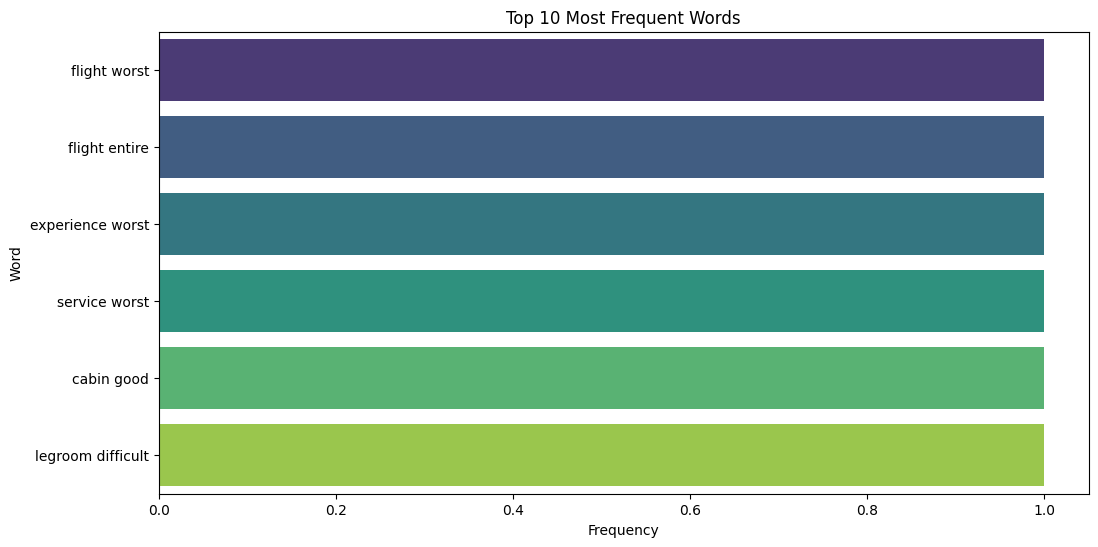

In [130]:
top_n = phrases_df.sort_values('freq', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_n['freq'], y=top_n['bigram_str'], palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 10 Most Frequent Words")
plt.show()


In [ ]:
aspect_descriptors = phrase_extraction(df_merge[['REVIEW_TEXT', 'TOPIC_1']], target_nouns)
df_merge['keywords'] = [[" ".join(keyword) for keyword in keywords]  for keywords in aspect_descriptors]

In [ ]:
df_merge.to_csv("data/qantas_reviews_data.csv")

### Create a new table containing all keywords for each review id

In [ ]:
df_merge.keywords

0             ['flight current', 'flight full']
1                                            []
2                                            []
3       ['bag small', 'bag small', 'bag pilot']
4                                            []
                         ...                   
1536           ['member female', 'crew stupid']
1537                       ['service inflight']
1538                           ['flight short']
1539                                         []
1540       ['flight available', 'arrival late']
Name: keywords, Length: 1541, dtype: object

In [ ]:
import ast

df_keywords = df_merge[['REVIEW_ID', 'keywords']]
df_keywords["keywords"] = df_keywords["keywords"].apply(ast.literal_eval)

C:\Users\admin\AppData\Local\Temp\ipykernel_16492\1148840079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keywords["keywords"] = df_keywords["keywords"].apply(ast.literal_eval)


In [136]:
df_keywords = df_keywords.explode('keywords').reset_index(drop=True)

In [ ]:
df_keywords.to_csv("data/review_keywords.csv")